In [1]:
"""
Import modules
"""

import turlib.turlib as tp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:

'''
Dictate the figure structure
'''

#sns.set_theme()
font = {'family': 'Trebuchet MS',
        'size': 22}

matplotlib.rc('font', **font)

In [3]:
'''
Load Control Matrix for reconstruction of pseudo-open modes
'''

G = pd.read_csv('G.csv', header=None)  # Gradient matrix
G = np.asarray(G)
Gc = G[1:16, :]  # first row is index

In [4]:
hRadOrd = 4  # higher radial order in the fit
lRadOrd = 2  # lower radial order in the fit
mRO = 0  # nbr of last radial orders excluded from the fit
modes_excluded = np.array([])  # Noll modes to exclud from the fit (focus)

# modes to fit

fRadOrds = np.arange(lRadOrd, hRadOrd + 1 - mRO)
fModes = np.array([], dtype=int)
for iRadOrd in range(fRadOrds.size):
    fModes = np.append(fModes, tp.modes_of_radial_order(fRadOrds[iRadOrd]))

print('Modes included in the fit: ',fModes)

Modes included in the fit:  [ 4  5  6  7  8  9 10 11 12 13 14 15]


In [5]:
J = tp.n_modes_from_radial_order(hRadOrd) # What is the Maximum mode ?

# Diameter of the ATs in the VLTI
D = 1.8

# Size of the matrix for the calculation of the cross-talk matrix
M = 30

# Fitted gradient columns
Gf = G.T[:, 1:J + 1]

# Pseudo inverse reconstructor
inv_Gf = np.linalg.pinv(Gf)
# Remaining gradient columns
Gr = G.T[:, J + 1:M + 2]

# cross-coupling matrix (As defined by Dai1996)
c = np.matmul(inv_Gf, Gr)

In [6]:
# slopes data
slopes_data = pd.read_csv('slopes_oopao.csv')
slopes_data = np.asarray(slopes_data)

# noise contribution - noise magnitude obtained from on-sky samples (N=50)
noise_cont = 2e-7
# measurement error contribution added to the slopes
err = np.random.normal(0, noise_cont, slopes_data.shape)
noise_slopes = slopes_data + err

# Value of the r0 (Fried parameter) used for the generation of the slopes
true_r0 = 0.136991 # [meters]

# Estimation at 20 seconds, with 500 Hz loop rate
time = int(20*500)

zernike_c_noise_f = np.matmul(noise_slopes, np.linalg.pinv(Gc))[:time].T
# removing piston, tip/tilt
zernike_c_noise = zernike_c_noise_f[3:]

bi2_noise = np.var(zernike_c_noise, axis=1)
fusco_noise = tp.noise_variance(zernike_c_noise)
recup_bi2 = bi2_noise - fusco_noise


"""
Fit the Zernike variances and compare results
"""

inv_Gf = np.linalg.pinv(Gc)

#creating an appropriate vector for the function (padding piston, tip/tilt as 0s, since they are not included in the real telemetry)
bi2_noise_extended = np.zeros(15)
bi2_noise_extended[3:] = bi2_noise

fusco_noise_extended = np.zeros(15)
fusco_noise_extended[3:] = fusco_noise


In [7]:
r0_v,L0_v,fitted_ai2 = tp.iterative_estimator(d = D, modes = fModes, ai2 = bi2_noise_extended,
                                              noise_estimate=  fusco_noise_extended, n_rec_modes=J, m=M, c_mat=c, full_vector=True, n_iter=5)

print(r'True r0 =',true_r0*100,' [cm]')
print(r'5th iteration r0 =', r0_v[-1]*100,'[cm]')
print(r'0th iteration r0 =', r0_v[0]*100,'[cm]')
print('Convergence bias to real r0 =', (r0_v[-1] - true_r0)/true_r0*100,'%')

True r0 = 13.6991  [cm]
5th iteration r0 = 13.874218535699983 [cm]
0th iteration r0 = 14.602750012930125 [cm]
Convergence bias to real r0 = 1.2783214641836578 %


In [8]:
mc_r0,mc_l0,r0_vector = tp.full_uncertainty_estimator(d = D, modes = fModes, ai2 = bi2_noise_extended,
                                                      noise_estimate=fusco_noise_extended, n_rec_modes=J, m=M, c_mat=c, n_samples=50)

In [9]:
print(r'True r0 =',true_r0*100,' [cm]')
print(r'5th iteration r0 =', mc_r0[0]*100,'[cm] +-',mc_r0[-1]/mc_r0[0]*100,'%')
print('Convergence bias to real r0 =', (mc_r0[0] - true_r0)/true_r0*100,'%')


True r0 = 13.6991  [cm]
5th iteration r0 = 13.879100134790292 [cm] +- 1.0640894613707426 %
Convergence bias to real r0 = 1.3139559152812406 %


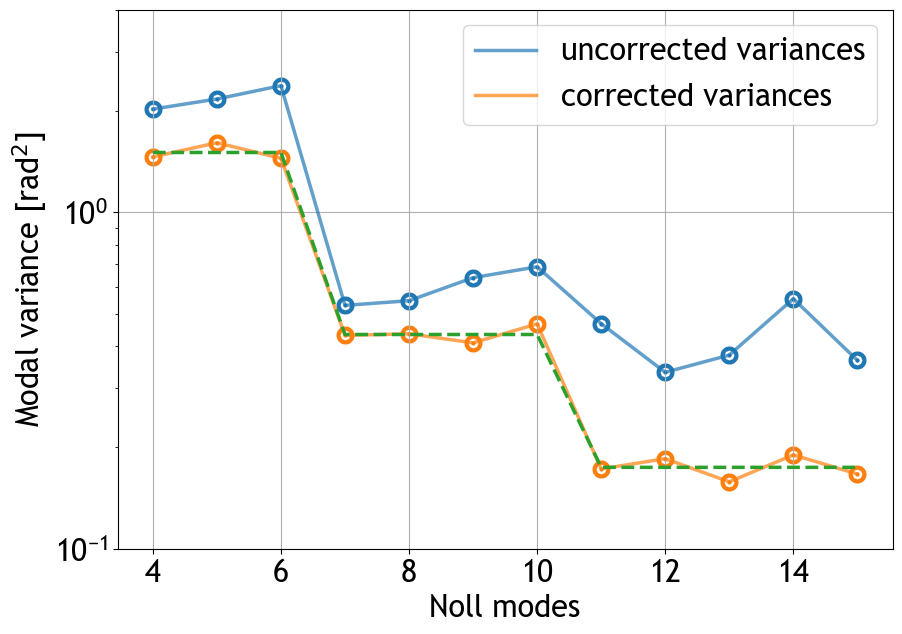

In [8]:
plt.figure(figsize=(10,7))

plt.plot(fModes,bi2_noise, lw=2.5, label = 'uncorrected variances', alpha=.7)
plt.scatter(fModes,bi2_noise, lw=10, marker='.', color='tab:blue')

plt.plot(fModes,fitted_ai2, lw=2.5, label = 'corrected variances', alpha=.7)
plt.scatter(fModes,fitted_ai2, lw=10, color='tab:orange', marker = '.')

plt.plot(fModes,tp.nz_variance(r0_v[-1],L0_v[-1],D,J)[3:],'--', lw= 2.5)
plt.grid()
plt.ylim(10**-1,4)
plt.legend()
plt.yscale('log')
plt.xlabel('Noll modes')
plt.ylabel(r'Modal variance [rad$^2$]')
plt.savefig('fitted_variances.svg')